Additional plots for the presentation.

In [2]:
import pandas as pd
import glob
import os
import datetime
# import pvlib
from pv_model import model_pv_power
from forecast_solar import get_solar_forecast_fast
import matplotlib.pyplot as plt
# import scipy
import numpy as np

Repeat what we did in previous notebooks, reading in specs, actuals, and forecasts. 

In [95]:
folder = 'output_specs' 
filename = 'agg_specs_orig_df.pkl'
file_to_read = os.path.join(folder, filename)
agg_specs_orig_df = pd.read_pickle(file_to_read)
num_plants = len(agg_specs_orig_df)

# timeseries data files
folder_ts = 'output_timeseries' 
filelist_ts = glob.glob(os.path.join(folder_ts, '*_actual_power_20240310-20250316.csv'))

agg_hsl = {}
agg_tel_net_out = {}

for plant_number in range(num_plants):
    # read in timeseries data from ERCOT
    ts_file = filelist_ts[plant_number]
    df_ts = pd.read_csv(ts_file,index_col=0,parse_dates=True,low_memory=False) #low_memory=False to avoid mixed variable type warning
    
    # outputs
    agg_hsl[plant_number] = df_ts['hsl']
    agg_tel_net_out[plant_number] = df_ts['telemetered_net_output']

# make dataframes 
agg_hsl_df = pd.concat(agg_hsl, axis=1)
agg_tel_net_out_df = pd.concat(agg_tel_net_out, axis=1)

# use HSL for observations
power_obs = agg_hsl_df.resample('1h').mean()

# import deterministic forecasts
power_fcasts_gfs_all = pd.read_csv('forecasts/power_fcasts_gfs_all.csv', parse_dates=['valid_time'], index_col='valid_time')
power_fcasts_ifs_all = pd.read_csv('forecasts/power_fcasts_ifs_all.csv', parse_dates=['valid_time'], index_col='valid_time')

# process
last_day = '2025-03-10'

power_fcasts_gfs = {}
power_fcasts_ifs = {}
power_obs_and_fcast = {}

for plant_number in range(num_plants):
    # pull plant data
    plant_data = agg_specs_orig_df[plant_number].to_dict()

    # get the power forecast for the plant
    power_fcasts_gfs = power_fcasts_gfs_all[power_fcasts_gfs_all['point']==plant_number]
    power_fcasts_ifs = power_fcasts_ifs_all[power_fcasts_ifs_all['point']==plant_number]

    # drop point column
    power_fcasts_gfs = power_fcasts_gfs.drop(columns=['point'])
    power_fcasts_ifs = power_fcasts_ifs.drop(columns=['point'])

    # adjust timestamps to beginning of interval to match observations
    power_fcasts_gfs.index = power_fcasts_gfs.index - pd.Timedelta('30min')
    power_fcasts_ifs.index = power_fcasts_ifs.index - pd.Timedelta('30min')

    # merge
    power_obs_and_fcast[plant_number] = pd.concat([power_obs[plant_number], power_fcasts_gfs, power_fcasts_ifs], axis=1, join='inner')

    # rename columns
    power_obs_and_fcast[plant_number].columns = ['power_obs', 'power_fcast_gfs', 'power_fcast_ifs']

    # make an averaged fcast
    power_obs_and_fcast[plant_number]['power_fcast_mean'] = (power_obs_and_fcast[plant_number]['power_fcast_gfs'] + power_obs_and_fcast[plant_number]['power_fcast_ifs']) / 2

    # trim to end before 2025-03-10
    power_obs_and_fcast[plant_number] = power_obs_and_fcast[plant_number][power_obs_and_fcast[plant_number].index < last_day]

# add week
day_one = (power_obs_and_fcast[0].index[0].floor('1d')).tz_convert(tz='US/Central')
power_obs_and_fcast_daily = {} # empty dict for daily energy dataframes

for i in range(num_plants):
    # convert timezone
    power_obs_and_fcast[i].index =  power_obs_and_fcast[i].index.tz_convert('US/Central')
    # add week
    power_obs_and_fcast[i]['week'] = np.floor((power_obs_and_fcast[i].index - day_one).days / 7)
    # daily totals of all columns but 'week', then add week number
    power_obs_and_fcast_daily[i] = power_obs_and_fcast[i].drop('week', axis=1).resample('1D').sum()
    power_obs_and_fcast_daily[i]['week'] = power_obs_and_fcast[i]['week'].resample('1D').min()

# weekly analysis
num_days = 7  # number of days out to schedule. currently can be up to 7. could be shorter, e.g., 5 to just schdeule Monday-Friday
weekly_optimal = {}
weekly_fcast_gfs = {}
weekly_fcast_ifs = {}
weekly_fcast_mean = {}
weekly_rand = {}
weekly_rand_avg = {}
for i in range(num_plants):
    weekly_energy_optimal_list = []
    weekly_energy_fcast_gfs_list = []
    weekly_energy_fcast_ifs_list = []
    weekly_energy_fcast_mean_list = []
    weekly_energy_random_list = []
    weekly_energy_random_avg_list = []
    for week in power_obs_and_fcast_daily[i]['week'].unique():
        # dataframe filtered to plant and week of interest
        df_daily_temp = power_obs_and_fcast_daily[i][power_obs_and_fcast_daily[i]['week']==week].iloc[:num_days]
        # weekly energy with optimal outage scheduling
        drop_day_number = df_daily_temp['power_obs'].argmin()
        we_opt = df_daily_temp.drop(df_daily_temp.index[drop_day_number])['power_obs'].sum()
        
        # weekly energy with forecast-based outage scheduling
        drop_day_number = df_daily_temp['power_fcast_gfs'].argmin()
        we_fcast_gfs = df_daily_temp.drop(df_daily_temp.index[drop_day_number])['power_obs'].sum()
        drop_day_number = df_daily_temp['power_fcast_ifs'].argmin()
        we_fcast_ifs = df_daily_temp.drop(df_daily_temp.index[drop_day_number])['power_obs'].sum()
        drop_day_number = df_daily_temp['power_fcast_mean'].argmin()
        we_fcast_mean = df_daily_temp.drop(df_daily_temp.index[drop_day_number])['power_obs'].sum()

        # weekly energy with all possible random days
        temp = []
        for j in range(num_days):
            we_rand = df_daily_temp.drop(df_daily_temp.index[j])['power_obs'].sum()
            temp.append(we_rand)
        weekly_energy_random_list.append(temp)
        weekly_energy_random_avg_list.append(np.mean(temp))

        weekly_energy_optimal_list.append(we_opt)
        weekly_energy_fcast_gfs_list.append(we_fcast_gfs)
        weekly_energy_fcast_ifs_list.append(we_fcast_ifs)
        weekly_energy_fcast_mean_list.append(we_fcast_mean)
    weekly_optimal[i] = weekly_energy_optimal_list
    weekly_fcast_gfs[i] = weekly_energy_fcast_gfs_list
    weekly_fcast_ifs[i] = weekly_energy_fcast_ifs_list
    weekly_fcast_mean[i] = weekly_energy_fcast_mean_list
    weekly_rand[i] = weekly_energy_random_list
    weekly_rand_avg[i]= weekly_energy_random_avg_list

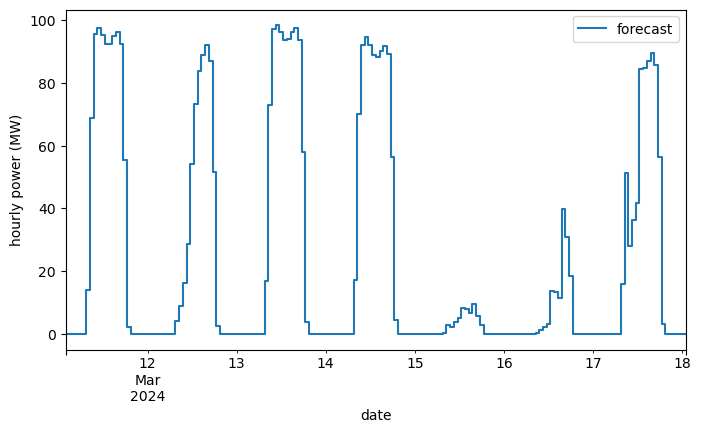

In [96]:
plant_number = 3

df_plot = power_obs_and_fcast[plant_number].copy().tz_convert('US/Central')
start = pd.Timestamp('2024-03-11 2:00').tz_localize('US/Central')
end = start + pd.Timedelta('7D')

# pad with zeros to get top and bottom plots nicely lined up
dr = pd.date_range(start, end, freq='1h')
df_plot = df_plot.reindex(dr).fillna(0)
mask = (df_plot.index >=start) & (df_plot.index <end)
df_plot = df_plot[mask]

# df_plot['power_fcast_ifs'].plot(drawstyle='steps-mid', label = 'forecast')
df_plot['power_fcast_gfs'].plot(drawstyle='steps-mid', label = 'forecast')
# df_plot['power_fcast_mean'].plot(drawstyle='steps-mid', label = 'mean')
# df_plot['power_obs'].plot(drawstyle='steps-mid', label = 'actual')
plt.ylabel('hourly power (MW)')
plt.xlabel('date')
# plt.gcf().autofmt_xdate()
plt.gcf().autofmt_xdate()
# plt.gcf().set_size_inches(6.4, 4)
# plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.23), ncol=2)
plt.gcf().set_size_inches(8, 5)
plt.legend()
plt.savefig('images/pres_hourly_fcast.png', dpi=400, bbox_inches='tight')
plt.show()

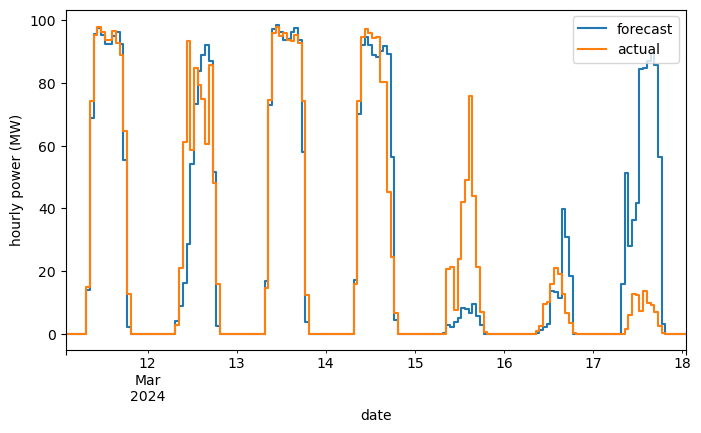

In [97]:
# df_plot['power_fcast_ifs'].plot(drawstyle='steps-mid', label = 'forecast')
df_plot['power_fcast_gfs'].plot(drawstyle='steps-mid', label = 'forecast')
# df_plot['power_fcast_mean'].plot(drawstyle='steps-mid', label = 'mean')
df_plot['power_obs'].plot(drawstyle='steps-mid', label = 'actual')
plt.ylabel('hourly power (MW)')
plt.xlabel('date')
# plt.gcf().autofmt_xdate()
plt.gcf().autofmt_xdate()
# plt.gcf().set_size_inches(6.4, 4)
plt.gcf().set_size_inches(8, 5)
plt.legend(loc='upper right')
plt.savefig('images/pres_hourly_fcast_act.png', dpi=400, bbox_inches='tight')
plt.show()

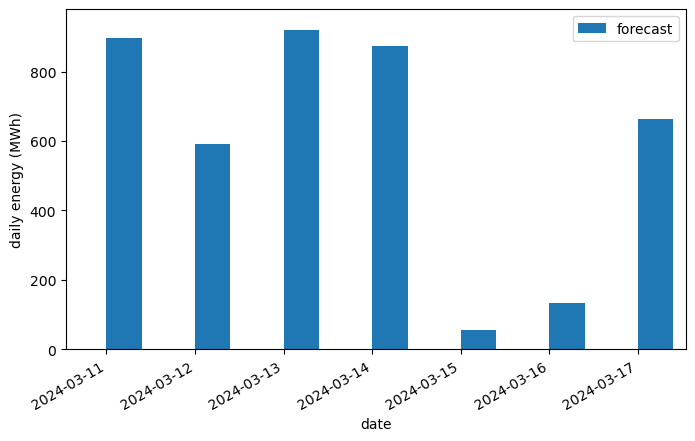

In [98]:
df_plot_daily = power_obs_and_fcast[plant_number].copy().tz_convert('US/Central').resample('1d').sum()
mask_daily = (df_plot_daily.index >=start.floor('1d')) & (df_plot_daily.index <end.floor('1d'))
df_plot_daily = df_plot_daily[mask_daily]

plt.bar(
    df_plot_daily.index,
    df_plot_daily['power_fcast_gfs'].values,
    width=0.4,
    align='edge',
    label='forecast')

plt.legend()
plt.xlabel('date')
plt.ylabel('daily energy (MWh)')
temp = plt.gca().get_xlim()
# plt.xlim([pd.Timestamp('2024-03-10 18:00'),temp[1]])
plt.xlim([pd.Timestamp('2024-03-10 18:00'),pd.Timestamp('2024-03-17 18:00')])
plt.ylim([0,980])
plt.gcf().autofmt_xdate()
plt.gcf().set_size_inches(8, 5)

plt.savefig('images/pres_daily_fcast.png', dpi=400, bbox_inches='tight')
plt.show()

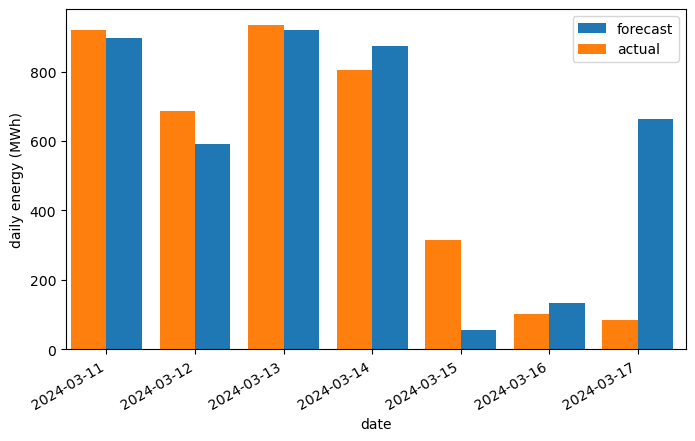

In [99]:
plt.bar(
    df_plot_daily.index,
    df_plot_daily['power_fcast_gfs'].values,
    width=0.4,
    align='edge',
    label='forecast')

plt.bar(
    df_plot_daily.index,
    df_plot_daily['power_obs'].values,
    width=-0.4,
    align='edge',
    label='actual')

plt.legend()
plt.xlabel('date')
plt.ylabel('daily energy (MWh)')
temp = plt.gca().get_xlim()
# plt.xlim([pd.Timestamp('2024-03-10 12:00'),temp[1]])
plt.xlim([pd.Timestamp('2024-03-10 18:00'),pd.Timestamp('2024-03-17 18:00')])
plt.ylim([0,980])
plt.gcf().autofmt_xdate()
plt.gcf().set_size_inches(8, 5)

plt.savefig('images/pres_daily_fcast_act.png', dpi=400, bbox_inches='tight')
plt.show()

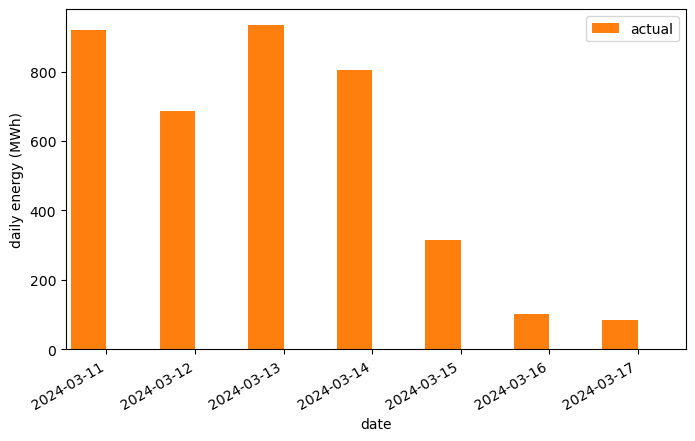

In [100]:
plt.bar(
    df_plot_daily.index,
    df_plot_daily['power_obs'].values,
    width=-0.4,
    align='edge',
    label='actual',
    color='C1')

plt.legend()
plt.xlabel('date')
plt.ylabel('daily energy (MWh)')
temp = plt.gca().get_xlim()
# plt.xlim([pd.Timestamp('2024-03-10 12:00'),temp[1]])
plt.xlim([pd.Timestamp('2024-03-10 18:00'),pd.Timestamp('2024-03-17 18:00')])
plt.ylim([0,980])
plt.gcf().autofmt_xdate()
plt.gcf().set_size_inches(8, 5)

plt.savefig('images/pres_daily_act.png', dpi=400, bbox_inches='tight')
plt.show()

In [106]:
print(weekly_optimal[plant_number][0])
print(weekly_fcast_gfs[plant_number][0])
print(weekly_rand_avg[plant_number][0])
print(weekly_rand_avg[plant_number][0]/7)

3763.4999999999995
3532.6249999999995
3296.9571428571426
470.9938775510204


In [107]:
(weekly_optimal[plant_number][0] - weekly_fcast_gfs[plant_number][0]) / (weekly_optimal[plant_number][0] - weekly_rand_avg[plant_number][0])

np.float64(0.4948634331557354)

Drop sites that we didn't use

In [109]:
agg_specs_orig_df_dropped = agg_specs_orig_df.drop([0, 5, 9], axis=1)

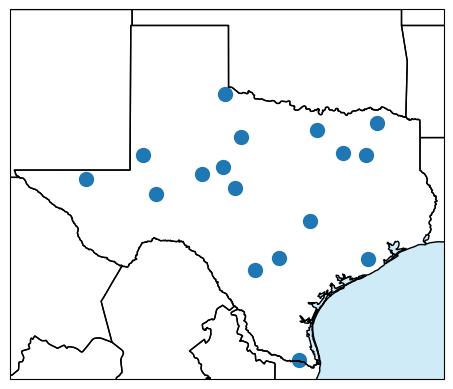

In [112]:
# import cartopy
import cartopy.crs as crs
import cartopy.feature as cfeature
from matplotlib.markers import MarkerStyle
fig = plt.figure()

ax = fig.add_subplot(1,1,1, projection=crs.PlateCarree())

ax.add_feature(cfeature.OCEAN, color="skyblue", alpha=0.4)
ax.add_feature(cfeature.STATES)

ax.set_extent([-106.8, -93.3, 25.5, 37],
              crs=crs.PlateCarree()) ## Important

plt.scatter(
    agg_specs_orig_df_dropped.T['longitude'],
    agg_specs_orig_df_dropped.T['latitude'],
    s=100)
# plt.colorbar(label='Relative loss reduction', fraction=0.046, pad=0.04)
plt.savefig('images/site_map.png', dpi=400, bbox_inches='tight')
plt.show()


In [ ]:
920.850 + 685.975 + 

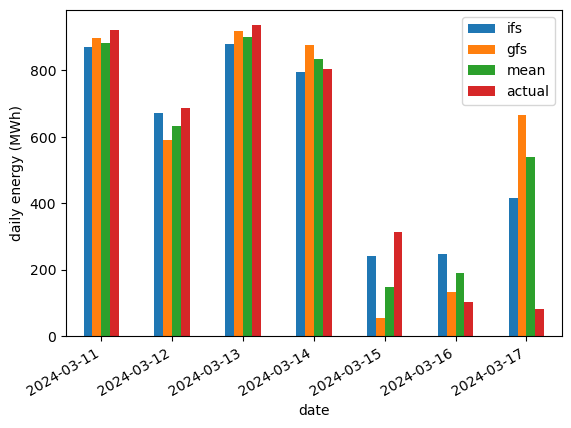

In [22]:
df_plot_daily = power_obs_and_fcast[plant_number].copy().tz_convert('US/Central').resample('1d').sum()
mask_daily = (df_plot_daily.index >=start.floor('1d')) & (df_plot_daily.index <end.floor('1d'))


df_plot_daily[['power_fcast_ifs', 'power_fcast_gfs', 'power_fcast_mean', 'power_obs']][mask_daily].plot(kind='bar')
labels = df_plot_daily[mask_daily].index.strftime('%Y-%m-%d')
plt.legend(['ifs', 'gfs', 'mean', 'actual'])
plt.gca().set_xticklabels(labels)
plt.xlabel('date')
plt.ylabel('daily energy (MWh)')
plt.gcf().autofmt_xdate()
# plt.savefig('images/sample_daily_energy_bar.png', dpi=400, bbox_inches='tight')
plt.show()

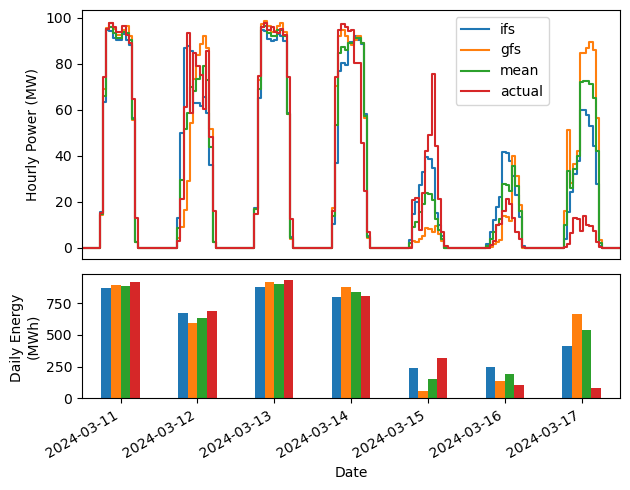

In [6]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(6.4, 5), height_ratios=[2, 1])

plant_number = 3

# first sub plot
df_plot = power_obs_and_fcast[plant_number].copy().tz_convert('US/Central')
start = pd.Timestamp('2024-03-11 2:00').tz_localize('US/Central')
end = start + pd.Timedelta('7D')

# pad with zeros to get top and bottom plots nicely lined up
dr = pd.date_range(start, end, freq='1h')
df_plot = df_plot.reindex(dr).fillna(0)

mask = (df_plot.index >=start) & (df_plot.index <end)
# df_plot.index = df_plot.index + pd.Timedelta('12h')
df_plot['power_fcast_ifs'][mask].plot(drawstyle='steps-mid', label = 'ifs', ax=ax1)
df_plot['power_fcast_gfs'][mask].plot(drawstyle='steps-mid', label = 'gfs', ax=ax1)
df_plot['power_fcast_mean'][mask].plot(drawstyle='steps-mid', label = 'mean', ax=ax1)
df_plot['power_obs'][mask].plot(drawstyle='steps-mid', label = 'actual', ax=ax1)
ax1.set_ylabel('Hourly Power (MW)')
ax1.set_xticklabels([])
ax1.set_xticks([], [])
ax1.minorticks_off()
ax1.legend(loc='upper right', bbox_to_anchor=(0.88, 1))

# second subplot
df_plot_daily = power_obs_and_fcast[plant_number].copy().tz_convert('US/Central').resample('1d').sum()
mask_daily = (df_plot_daily.index >=start.floor('1d')) & (df_plot_daily.index <end.floor('1d'))


df_plot_daily[['power_fcast_ifs', 'power_fcast_gfs', 'power_fcast_mean', 'power_obs']][mask_daily].plot(kind='bar', ax=ax2, legend=False)
labels = df_plot_daily[mask_daily].index.strftime('%Y-%m-%d')
# ax2.legend(['ifs', 'gfs', 'mean', 'actual'])
ax2.set_xticklabels(labels)

fig.autofmt_xdate()

ax2.set_xlabel('Date')
ax2.set_ylabel('Daily Energy \n(MWh)')

fig.tight_layout()
# plt.savefig('images/sample_hourly_and_daily.png', dpi=400, bbox_inches='tight')